In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Describe your dataset. 
Describe and explore your dataset in the initial section of your Report. What does your data contain and what is its background? Where does it come from? Why is it interesting or significant? Conduct summary statistics and produce visualizations for the particular variables from the dataset that you will use.

## Dataset: The Civil Rights Data Collection, school-level data for 2015-2016

The Civil Rights Data Collection (CRDC) is a biennial survey required by the U.S. Department of Education’s (Department) Office for Civil Rights (OCR) since 1968. (Note, howerever, that survey content changes over time.)

The 2015–16 CRDC (the most recent year published) collects data from all public local educational agencies (LEAs, ie *School Districts*) and schools, including 
- long-term secure juvenile justice facilities
- charter schools
- alternative schools
- and schools serving students with disabilities

with a responce rate of 99.8% from __17,337 LEAs and 96,360 schools__. Speicifically, I will be looking at the finer-grained *data disagregated by school*.

### Data content and format
Each school (row) in the dataset includes 1,800 columns (typically a student count disagregated by race and gender) regarding 32 general topics. __The topics I will investigate are in bold, and corrospond just over 1,000 columns__:

__'Identification', 'School Characteristics', 'Enrollment','Suspensions', 'Expulsions', 'Transfers', 'Referrals and Arrests', 'Offenses', 'Restraint and Seclusion', 'Chronic Absenteeism', 'Retention', 'Justice Facility',__ 
       'Gifted and Talented', 'Dual Enrollment', 'Credit Recovery',
       'Algebra I', 'Geometry', 'Algebra II', 'Calculus',
       'Advanced Mathematics', 'Biology', 'Chemistry', 'Physics',
       'Single-sex Classes', 'Advanced Placement',
       'International Baccalaureate', 'SAT and ACT Exams',
       'Corporal Punishment',
       'Harassment and Bullying',
       'Single-Sex Athletics', 'School Expenditures', 'School Support',
       


### Known issues with dataset
From the CRDC report: "An important consideration for response rates is that the reporting process requires all schools and LEAs to respond to each survey item on the CRDC. Some LEAs, that did not have complete data, __reported a zero value__. It is not possible to determine all possible situations where this may have occurred. As such, it may be the case that the item response rates may be positively biased. For the large majority of CRDC survey items, __the rate of missing data ranged from 0-5% of reported values__."

- add more missing data/input errors
- id to scientific notaiotn

In [21]:
CRDC_RECORD_LAYOUT = 'CRDC 2015-16 School Data Record Layout.csv'
column_descriptions = pd.read_csv(CRDC_RECORD_LAYOUT, encoding="ISO-8859-1")
column_descriptions['Module'].unique()

array(['Identification', 'School Characteristics', 'Enrollment',
       'Gifted and Talented', 'Dual Enrollment', 'Credit Recovery',
       'Algebra I', 'Geometry', 'Algebra II', 'Calculus',
       'Advanced Mathematics', 'Biology', 'Chemistry', 'Physics',
       'Single-sex Classes', 'Advanced Placement',
       'International Baccalaureate', 'SAT and ACT Exams',
       'Corporal Punishment', 'Suspensions', 'Expulsions', 'Transfers',
       'Referrals and Arrests', 'Offenses', 'Restraint and Seclusion',
       'Harassment and Bullying', 'Chronic Absenteeism', 'Retention',
       'Single-Sex Athletics', 'School Expenditures', 'School Support',
       'Justice Facility'], dtype=object)

## Intro: Summary Statistics and Exploration

In [4]:
MULTIPLE_SUSPENSIONS = [
'SCH_DISCWODIS_MULTOOS_HI_M',
'SCH_DISCWODIS_MULTOOS_HI_F',
# 'SCH_DISCWODIS_MULTOOS_AM_M',
# 'SCH_DISCWODIS_MULTOOS_AM_F',
# 'SCH_DISCWODIS_MULTOOS_AS_M',
# 'SCH_DISCWODIS_MULTOOS_AS_F',
# 'SCH_DISCWODIS_MULTOOS_HP_M',
# 'SCH_DISCWODIS_MULTOOS_HP_F',
'SCH_DISCWODIS_MULTOOS_BL_M',
'SCH_DISCWODIS_MULTOOS_BL_F',
'SCH_DISCWODIS_MULTOOS_WH_M',
'SCH_DISCWODIS_MULTOOS_WH_F',
# 'SCH_DISCWODIS_MULTOOS_TR_M',
# 'SCH_DISCWODIS_MULTOOS_TR_F',
'TOT_DISCWODIS_MULTOOS_M',
'TOT_DISCWODIS_MULTOOS_F']

# Overal demographics at schools
DEMOGRAPHIC_COUNT_COLS = [
    'SCH_ENR_HI_M',
    'SCH_ENR_HI_F',
#     'SCH_ENR_AM_M',
#     'SCH_ENR_AM_F',
#     'SCH_ENR_AS_M',
#     'SCH_ENR_AS_F',
#     'SCH_ENR_HP_M',
#     'SCH_ENR_HP_F',
    'SCH_ENR_BL_M',
    'SCH_ENR_BL_F',
    'SCH_ENR_WH_M',
    'SCH_ENR_WH_F',
#     'SCH_ENR_TR_M',
#     'SCH_ENR_TR_F',
    'TOT_ENR_M',
    'TOT_ENR_F'
]

# Expulsion
EXPULSION_ZERO_TOLERANCE = [
'SCH_DISCWODIS_EXPZT_HI_M',
'SCH_DISCWODIS_EXPZT_HI_F',
# 'SCH_DISCWODIS_EXPZT_AM_M',
# 'SCH_DISCWODIS_EXPZT_AM_F',
# 'SCH_DISCWODIS_EXPZT_AS_M',
# 'SCH_DISCWODIS_EXPZT_AS_F',
# 'SCH_DISCWODIS_EXPZT_HP_M',
# 'SCH_DISCWODIS_EXPZT_HP_F',
'SCH_DISCWODIS_EXPZT_BL_M',
'SCH_DISCWODIS_EXPZT_BL_F',
'SCH_DISCWODIS_EXPZT_WH_M',
'SCH_DISCWODIS_EXPZT_WH_F',
# 'SCH_DISCWODIS_EXPZT_TR_M',
# 'SCH_DISCWODIS_EXPZT_TR_F',
'TOT_DISCWODIS_EXPZT_F',
'TOT_DISCWODIS_EXPZT_M']

EXPULSION_WO_ED = [
'SCH_DISCWODIS_EXPWOE_HI_M',
'SCH_DISCWODIS_EXPWOE_HI_F',
# 'SCH_DISCWODIS_EXPWOE_AM_M',
# 'SCH_DISCWODIS_EXPWOE_AM_F',
# 'SCH_DISCWODIS_EXPWOE_AS_M',
# 'SCH_DISCWODIS_EXPWOE_AS_F',
# 'SCH_DISCWODIS_EXPWOE_HP_M',
# 'SCH_DISCWODIS_EXPWOE_HP_F',
'SCH_DISCWODIS_EXPWOE_BL_M',
'SCH_DISCWODIS_EXPWOE_BL_F',
'SCH_DISCWODIS_EXPWOE_WH_M',
'SCH_DISCWODIS_EXPWOE_WH_F',
# 'SCH_DISCWODIS_EXPWOE_TR_M',
# 'SCH_DISCWODIS_EXPWOE_TR_F',
'TOT_DISCWODIS_EXPWOE_F',
'TOT_DISCWODIS_EXPWOE_M']

EXPULSION_W_ED = [
'SCH_DISCWODIS_EXPWE_HI_M',
'SCH_DISCWODIS_EXPWE_HI_F',
# 'SCH_DISCWODIS_EXPWE_AM_M',
# 'SCH_DISCWODIS_EXPWE_AM_F',
# 'SCH_DISCWODIS_EXPWE_AS_M',
# 'SCH_DISCWODIS_EXPWE_AS_F',
# 'SCH_DISCWODIS_EXPWE_HP_M',
# 'SCH_DISCWODIS_EXPWE_HP_F',
'SCH_DISCWODIS_EXPWE_BL_M',
'SCH_DISCWODIS_EXPWE_BL_F',
'SCH_DISCWODIS_EXPWE_WH_M',
'SCH_DISCWODIS_EXPWE_WH_F',
# 'SCH_DISCWODIS_EXPWE_TR_M',
# 'SCH_DISCWODIS_EXPWE_TR_F',
'TOT_DISCWODIS_EXPWE_F',
'TOT_DISCWODIS_EXPWE_M']

# Officers, counselors
COUNSELOR_STAFF = ['SCH_FTESERVICES_NUR', 'SCH_FTESERVICES_PSY','SCH_FTESERVICES_SOC']
SECURITY_STAFF = ['SCH_FTESECURITY_LEO', 'SCH_FTESECURITY_GUA']

JUSTICE_FACILITY = ['SCH_JJTYPE']

cols_of_interest = []
cols_of_interest += MULTIPLE_SUSPENSIONS
cols_of_interest += DEMOGRAPHIC_COUNT_COLS 
cols_of_interest += EXPULSION_ZERO_TOLERANCE + EXPULSION_W_ED + EXPULSION_WO_ED
cols_of_interest += COUNSELOR_STAFF + SECURITY_STAFF + JUSTICE_FACILITY

## Load All Schools Data (after downlaoding)
[Find this data in this Google Drive Folder.](https://drive.google.com/file/d/1LVRwFWpevvqGvMLlNt95BXmLVmBXfG0a/view?usp=sharing)

In [22]:
DATA_FILE = 'data (download CSVs here)/crdc-data-with-lat-long.csv'
basic_columns = ['SCH_NAME', 'LEA_STATE_NAME', 'LAT1516', 'LON1516']
crdc_data = pd.read_csv(
    DATA_FILE,
    usecols=basic_columns+cols_of_interest,
    low_memory=False,
    encoding="ISO-8859-1"
)
crdc_data

,LEA_STATE_NAME,SCH_NAME,SCH_ENR_HI_M,SCH_ENR_HI_F,SCH_ENR_BL_M,SCH_ENR_BL_F,SCH_ENR_WH_M,SCH_ENR_WH_F,TOT_ENR_M,TOT_ENR_F,...,TOT_DISCWODIS_EXPZT_M,TOT_DISCWODIS_EXPZT_F,SCH_FTESECURITY_LEO,SCH_FTESECURITY_GUA,SCH_FTESERVICES_NUR,SCH_FTESERVICES_PSY,SCH_FTESERVICES_SOC,SCH_JJTYPE,LAT1516,LON1516
0,ALABAMA,Wallace Sch - Mt Meigs Campus,5,0,71,0,50,0,128,0,...,0,0,-9.00,2.0,0.00,2.00,0.0,-7,32.374812,-86.082360
1,ALABAMA,McNeel Sch - Vacca Campus,0,0,38,0,14,0,52,0,...,0,0,-9.00,2.0,0.00,1.00,0.0,-7,33.583385,-86.710058
2,ALABAMA,Alabama Youth Services,0,0,554,0,323,0,908,0,...,0,0,-9.00,2.0,0.00,0.00,0.0,-9,32.374847,-86.082332
3,ALABAMA,AUTAUGA CAMPUS,2,0,17,0,14,0,38,0,...,0,0,-9.00,0.0,0.00,0.00,0.0,-7,NaN,NaN
4,ALABAMA,Albertville Middle School,140,143,11,5,194,185,358,346,...,0,0,1.00,0.0,1.00,0.00,0.0,-9,34.260194,-86.206174
5,ALABAMA,Albertville High Sch,260,221,20,20,350,398,645,650,...,0,0,1.00,1.0,1.00,0.00,0.0,-9,34.262154,-86.204863
6,ALABAMA,Evans Elem Sch,161,173,17,14,194,191,381,389,...,0,0,1.00,0.0,1.00,0.00,0.0,-9,34.273161,-86.220086
7,ALABAMA,Albertville Elem Sch,218,215,11,8,188,176,430,417,...,0,0,1.00,0.0,1.00,0.00,0.0,-9,34.253251,-86.221834
8,ALABAMA,Big Spring Lake Kinderg Sch,134,128,11,5,110,92,264,234,...,0,0,1.00,0.0,1.00,0.00,0.0,-9,34.290220,-86.192490
9,ALABAMA,Albertville Primary Sch,281,269,20,17,227,230,555,534,...,0,0,1.00,0.0,1.00,0.00,0.0,-9,34.253251,-86.221834


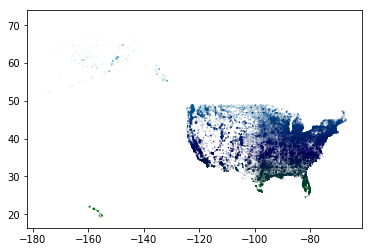

In [6]:
plt.scatter(x=crdc_data['LON1516'], y=crdc_data['LAT1516'], c=crdc_data['LAT1516'], s=0.005, cmap='ocean')

# Ask and answer analytic questions. 
Ask three analytic questions and answer each one with a combination of statistics and visualizations. These analytic questions can focus on individuals behaviors or comparisons of the population.

## Overview of questions
Discussions of "The School to Prison Pipeline" and its causes largely center on a few interrelated factors:
- Disproportionate suspensions, particularly towards black and disabled students
- Police Presence on campus, especially in contrast to lack of counselors and mental health proffessionals
- The rate at which students are refered to the criminal justice system, often believed to be interrelated to police presence.
- "Zero tolerence" policies in schools

While the most important aspect to understand is causality, we're limited by this data. Instead, these questions will explore the extend and nature of these key factors, as visible in the data.

## Question 1: How disproportionate are suspensions[ and referals] across race and gender?

#### Likelyhood Calculation helper functions

In [18]:
RACES = ['BL', 'WH', 'HI']
SEXES = ['M', 'F']
POP_LOWER_BOUND = 50 # Remove populations (e.g. white male) smaller than this threshold


# 1. Plotting

def plot_measure_accross_all_demographics(df, calculation, measure, bounds=[0,1]):
    figure_num = 0
    plt.figure(figsize=(20,6))
    for sex_index, sex in enumerate(SEXES):
        for race_index, race in enumerate(RACES):
            figure_num += 1
            likelyhood = f'{calculation}_{measure}_{race}_{sex}'
            curr_dem_data = df[pd.notnull(data[likelyhood])]
            plt.subplot(len(SEXES), len(RACES), figure_num)
            plt.scatter(x=curr_dem_data['LON1516'], y=curr_dem_data['LAT1516'], c=curr_dem_data[likelyhood], s=1, alpha=1, cmap='coolwarm')
            plt.title(f'{race}_{sex}, avg: {round(curr_dem_data[likelyhood].mean(), 2)}, n: {curr_dem_data[likelyhood].count()}')
#             plt.colorbar()
            plt.clim(*bounds)
            plt.axis('off')
    plt.subplots_adjust(wspace=0.8, hspace=0.6)
    plt.show()
    

# 2. Calculations

# ITERATIVE FUNCTION which appends likelyhood columns to the df for all demographics
# Flag parameter 'comarison_race' lets you compare how many times the first races is likely to be
# affected as the second race.
def calculate_likelyhood_comparisons(df, measure, comparison_race=None, races=RACES, sexes=SEXES, lower_bound=POP_LOWER_BOUND):
    df = remove_schools_with_pop_less_than(lower_bound)
    for sex in sexes:
        for race in races:
            df = calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, sex)
    return df


def remove_schools_with_pop_less_than(lower_bound):
    filter_col_df = df[DEMOGRAPHIC_COUNT_COLS]
    filtered_df = filter_col_df[filter_col_df >= lower_bound].dropna()
    return df.merge(filtered_df)


def calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, comparison_sex):
    likelyhood = get_percentage_affected(df, measure, race, sex)
    column_name = f'PERCENT_AFFECTED_{measure}_{race}_{sex}'
    if comparison_race:
        likelyhood = likelyhood / get_percentage_affected(df, measure, comparison_race, comparison_sex)
        column_name = f'LH_COMPARED_TO_WH_FOR_{measure}_{race}_{sex}'
    likelyhood = likelyhood[(likelyhood != np.inf) & (pd.notnull(likelyhood)) & (likelyhood > 0)]  # Filter out infinity and NaN
    return df.merge(
        likelyhood.to_frame(column_name),
        how='left',
        left_index=True,
        right_index=True,
    )


def get_percentage_affected(df, measure, race, sex):
    affected = f'{measure}_{race}_{sex}'  # e.g. 'SCH_DISCWODIS_MULTOOS_BL_M'
    pop_total = f'SCH_ENR_{race}_{sex}'  # e.g. 'SCH_ENR_TR_M' 
    return df[affected] / df[pop_total]      


#### (Apply any high-level filters as needed)

In [19]:
state_name = 'NORTH CAROLINA'
df = crdc_data#[crdc_data['LEA_STATE_NAME'] == state_name]

### Percent of demographic given at least one Suspension

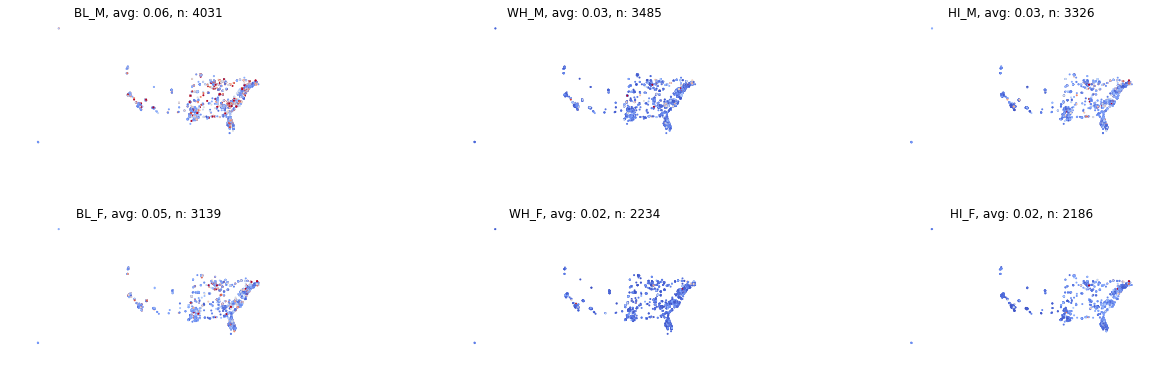

In [20]:
data = calculate_likelyhood_comparisons(df, 'SCH_DISCWODIS_MULTOOS')  # "more than one out of school suspension"
calculation = 'PERCENT_AFFECTED' 
measure = 'SCH_DISCWODIS_MULTOOS'
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[0, 0.15])

### How many times more likely to be suspended are blank and latino students than white students?
For the above "percent of population affected" plots, it's near impossible to compare the severity *across a single school*. One way to zero on on this is to color schools by *how much more likely* a certain population is to be affeced __compared to the least affected population__. This measure might reveal schools where, even if a demogrpahic is severely affected, so were other demographics.

How likelyhood comparisons are calculated: 

`Percent of X pop affected / Percent of White counterpart population affected`

In [9]:
data = calculate_likelyhood_comparisons(df, 'SCH_DISCWODIS_MULTOOS', comparison_race='WH')  # "more than one out of school suspension"
calculation = 'LH_COMPARED_TO_WH_FOR' 
measure = 'SCH_DISCWODIS_MULTOOS'
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[1, 4])

NameError: name 'df' is not defined

#### Notes:
- TO DO: show the CONVERSE: which schools are excluded becuase they don't have a significant enough number of a race?

## Question 2: What impact have "Zero-tolerance" policies had on expulsion?

In [ ]:
# SCH_DISCWODIS_EXPZT: "students without disabilities expelled on zero tolerance policy"
# ISSUE: There are only 1,200 schools with non-zero values for both WHITE/BLACK students, for example
# explusion_zero_tolerance = calculate_likelyhood_comparisons(crdc_data, 'SCH_DISCWODIS_EXPZT')

### 11,000 schools suspended at least one student. *15.2%* of those came via Zero Tolerance polices.

In [60]:
# Clean, filter to just exponentials
expulsion_cols = ['TOT_DISCWODIS_EXPZT_M', 'TOT_DISCWODIS_EXPWOE_M', 'TOT_DISCWODIS_EXPWE_M']
exp_df = crdc_data[expulsion_cols]
exp_df = exp_df[exp_df >= 0].dropna()

# convenience names
zt = exp_df['TOT_DISCWODIS_EXPZT_M']
we = exp_df['TOT_DISCWODIS_EXPWE_M']
wo = exp_df['TOT_DISCWODIS_EXPWOE_M']
# exp_df = exp_df[(zt>0) | (we>0) | (wo>0)]
# zt = exp_df['TOT_DISCWODIS_EXPZT_M']
# we = exp_df['TOT_DISCWODIS_EXPWE_M']
# wo = exp_df['TOT_DISCWODIS_EXPWOE_M']

# Of schools that gave at least one suspension... 
# What percentage of suspensions are from Zero Tolerance?
print(zt.mean() / (we.mean() + wo.mean()))
# zt_percentage

0.15244836098871908
93957


### Zero Tolerance policies impact 2% of white students, but about *4% and 5%* of black and latino students, respectively, for schools who gave out at least one Zero Tolerance based expulsion for that demographic.

- Question: Is this analysis potentially distorted? Should we address *how many schools gave ZT based expulsions at all?* It seems only ~1% of schools have given ZT expulsions for each respective demographic...

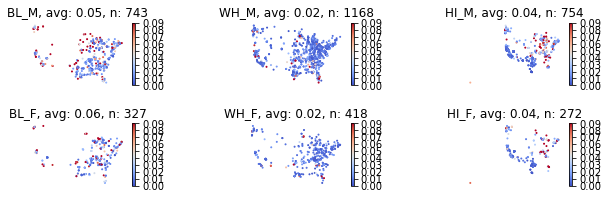

In [76]:
measure = 'SCH_DISCWODIS_EXPZT'
calculation = 'PERCENT_AFFECTED'
data = calculate_likelyhood_comparisons(df, measure, lower_bound=1)
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[0,0.09])

## Question 3: What is the proportion of campus Counselor, Psychologists etc vs campus Police Officers? 
We'll do seperate investigate Justice Facilities seperately, since we'd expect greater police officer presence there.
__A Data entry, system-level error__ on the form filled in by schools caused only __22,000 schools__ to correctly enter the number of Law Enforcement Officers on campus. Where this system error occurred, the value is `-9`.
Consider:
- scatter plot
- plot counselr/police ratio against outcomes (eg suspension), in scatter or even just binned bars

In [85]:
# SCH_FTESECURITY_LEO
# SCH_FTESECURITY_GUA
# SCH_FTESERVICES_NUR
# SCH_FTESERVICES_PSY
# SCH_FTESERVICES_SOC
# SCH_JJTYPE
# Filter out any negative numbers, which signal data errors
staff_df = crdc_data[crdc_data[COUNSELOR_STAFF + SECURITY_STAFF + JUSTICE_FACILITY] >= 0]
# Replace NaN with 

### Non justice faciitly

In [95]:
staff_df#['SCH_FTESECURITY_LEO'].describe()
staff_df[staff_df['SCH_JJTYPE'] == '-9']

,LEA_STATE_NAME,SCH_NAME,SCH_ENR_HI_M,SCH_ENR_HI_F,SCH_ENR_BL_M,SCH_ENR_BL_F,SCH_ENR_WH_M,SCH_ENR_WH_F,TOT_ENR_M,TOT_ENR_F,...,TOT_DISCWODIS_EXPZT_M,TOT_DISCWODIS_EXPZT_F,SCH_FTESECURITY_LEO,SCH_FTESECURITY_GUA,SCH_FTESERVICES_NUR,SCH_FTESERVICES_PSY,SCH_FTESERVICES_SOC,SCH_JJTYPE,LAT1516,LON1516
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,0.00,0.00,0.0,-9,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,0.0,1.00,0.00,0.0,-9,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,1.0,1.00,0.00,0.0,-9,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,0.0,1.00,0.00,0.0,-9,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,0.0,1.00,0.00,0.0,-9,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,0.0,1.00,0.00,0.0,-9,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.00,0.0,1.00,0.00,0.0,-9,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.33,0.0,0.33,0.00,0.0,-9,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.50,0.0,0.50,0.00,0.0,-9,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.25,0.00,0.0,-9,NaN,NaN


### Justice facilities

In [ ]:
staff_df[staff_df['SCH_JJTYPE'] != '-9']

# Propose further research.
Lastly, make a proposal for a realistic future research project on this dataset that would use some data science techniques you'd like to learn in the bootcamp. Just like your earlier questions, your research proposal should present one or more clear questions. Then you should describe the techniques you would apply in order to arrive at an answer.